In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sionna
from sionna.rt import load_scene
from matplotlib.colors import ListedColormap
import importlib
import SceneConfigSionna  
import BeamformingCalc
importlib.reload(SceneConfigSionna) 
importlib.reload(BeamformingCalc) 
from SceneConfigSionna import SceneConfigSionna
from BeamformingCalc import svd_bf, nulling_bf
import random

✅ Using GPU: /physical_device:GPU:0
✅ Using GPU: /physical_device:GPU:0


In [42]:
# scenegen bbox -105.097 40.0371 -105.06 40.0697 --data-dir scenes/Denver
# scene = load_scene("../Denver/denver.xml")
# scene = load_scene("../Denver_Scene/Boulder2_2/Boulder2.xml")
scene = load_scene("../blouder_plane_itu3/boulder_plane_itu.xml")
# scene = load_scene("../Denver_Scene/Boulder/Boulder.xml")

In [ ]:

nbs = 1
nsect = 3
ntn_rx=300
tn_rx=0
bs_dist_min=35
bs_dist_max=3000

tx_antenna_rows = 4
tx_antenna_cols = 16
tn_rx_antenna_rows = 1
tn_rx_antenna_cols = 1
tx_antennas = tx_antenna_rows*tx_antenna_cols
tn_antennas = tn_rx_antenna_rows*tn_rx_antenna_cols



ntaps = 512
bandwidth= 100e6
l_min=-64
l_max = ntaps + l_min - 1

In [ ]:
azimuth = np.random.uniform(0, 360)
elevation = np.random.uniform(25, 90)
SceneConfig = SceneConfigSionna(scene, nbs = nbs, nsect = nsect, fc =9.999e9)
SceneConfig.compute_positions(ntn_rx=ntn_rx, tn_rx=tn_rx,  azimuth=azimuth, elevation =elevation,
                                centerBS=True, bs_dist_min=bs_dist_min, bs_dist_max=bs_dist_max)
SceneConfig.compute_paths(tx_rows = tx_antenna_rows, tx_cols = tx_antenna_cols, tn_rx_rows = tn_rx_antenna_rows, 
                        tn_rx_cols = tn_rx_antenna_cols, max_depth=5,  bandwidth=bandwidth,l_min=l_min, l_max =l_max ,pathstaps = True)
a_ntn = SceneConfig.a_ntn
tau_ntn = SceneConfig.tau_ntn
tau_ntn[tau_ntn == -1.0] = 0.0
taps_ntn = SceneConfig.taps_ntn
h_time = SceneConfig.h_time
print(tau_ntn.shape)
print(a_ntn.shape)
print(taps_ntn.shape)
print(h_time.shape)

In [ ]:
EkT = -174    # Noise energy in dBm/Hz, antenna temperature for vsat: 290K
bandwidth = 100e6  #Hz
Tx_power_dbm = 30 # dbm

NF = 7  # Noise figure in dB
N0_dBm = EkT + 10 * np.log10(bandwidth ) + NF
time = 20e-6 # preamble TX time
scale_db = Tx_power_dbm-NF-EkT + 10*np.log10(time)
# scale_db = Tx_power_dbm-NF-EkT + 10*np.log10(time)-10*np.log10(bandwidth)
scale = 10**(0.1*scale_db)


# h = taps_ntn[1,:,0,0,0,:]
h = h_time[0,1,:,0,0,0,:]
h = np.sqrt(scale)*h
print(scale_db)
w = 1/np.sqrt(2)*(np.random.normal(0,1,h.shape) + 1j*np.random.normal(0,1,h.shape))
hnoisy = h + w
h_avg = 10 * np.log10(np.mean(np.abs(hnoisy)**2, axis=0))
t = np.arange(l_min,l_max+1)/bandwidth*1e9
a = a_ntn[1,0,0,:,:,0]
apow = 10*np.log10(np.sum(np.abs(a)**2, axis=0))
tau = tau_ntn[1,0,:]
tap_energy = scale_db + apow

150.0102999566398


/tmp/ipykernel_271022/1329788970.py:22: RuntimeWarning: divide by zero encountered in log10
  apow = 10*np.log10(np.sum(np.abs(a)**2, axis=0))


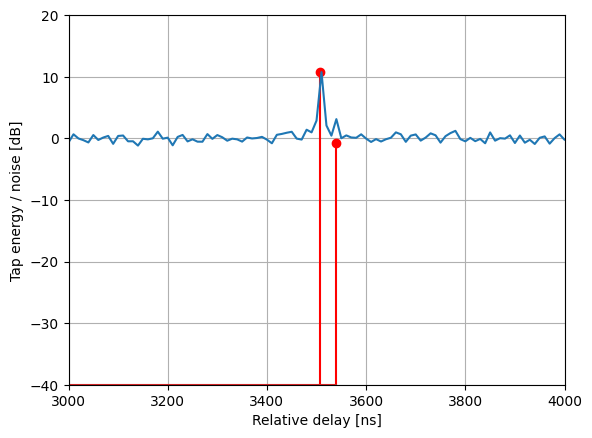

In [77]:
# Set the axis limits
ymax = np.max(h_avg)
ymax = np.maximum(ymax, np.max(tap_energy))
ymax = np.ceil(ymax/10)*10
ymin = np.minimum(ymax-60,-5)
plt.ylim([ymin, ymax])

# Plot the true paths and the estimated channel response
plt.stem(tau*1e9, tap_energy, bottom=ymin, linefmt='r', markerfmt='r', label='True')
plt.plot(t, h_avg, label='Estimated')
plt.xlim([3000, 4000])
# plt.ylim([-2, 5])
plt.grid()
plt.xlabel('Relative delay [ns]')
_ = plt.ylabel('Tap energy / noise [dB]')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2


bandwidth   = 100e6         #  MHz

p_fa = 1 / bandwidth       # one false alarm per second
tail  = 1 - p_fa              
N_rx_list = [32, 64, 128]                 # number of receive antennas
dof_list  = [2*n for n in N_rx_list]      

thresholds_Z  = {}   # on Z = 2‖r‖² / N0
thresholds_t  = {}   # on t  with decision  ‖r‖² ≥ t N0
thresholds_E  = {}   # energy in watts  E = t·N0

for dof in dof_list:
    z_thr          = chi2.ppf(tail, dof)      # Z threshold
    t_thr          = z_thr / 2                # decision threshold factor
    thresholds_Z[dof] = z_thr
    thresholds_t[dof] = t_thr

for N_rx, dof in zip(N_rx_list, dof_list):
    print(f"N_rx = {N_rx:3d}:  t = {thresholds_t[dof]:.2f} ")


N_rx =  32:  t = 74.48 
N_rx =  64:  t = 119.48 
N_rx = 128:  t = 201.97 


In [11]:
from scipy.stats import chi2
N_rx_list = [32, 64, 128]   
B = 100e6               
p_fa = 1 / B            
for N_rx in N_rx_list:
    t = chi2.ppf(1 - p_fa, 2 * N_rx) / 2     # dof = 2*N_rx
    print(f"N_rx={N_rx:<3}  t={t:.2f}")


N_rx=32   t=74.48
N_rx=64   t=119.48
N_rx=128  t=201.97


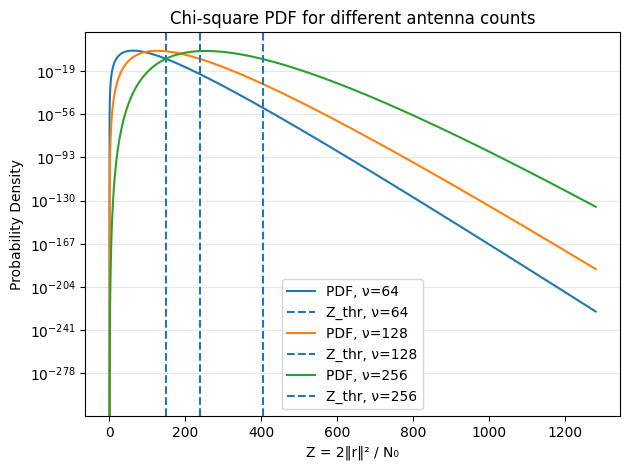

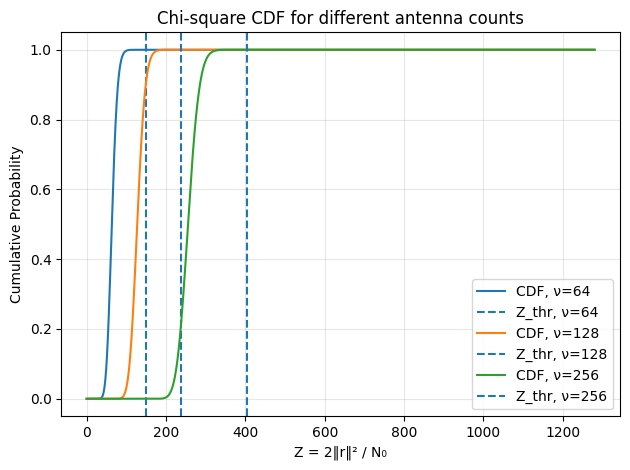

In [12]:

# ---------- Plot range ----------
Z_max = 5 * max(dof_list)   # show up to 5×mean

z_axis = np.linspace(0, Z_max, 4000)

# ---------- PDF plot ----------
plt.figure()
for dof in dof_list:
    pdf = chi2.pdf(z_axis, dof)
    plt.plot(z_axis, pdf, label=f'PDF, ν={dof}')
    # threshold line
    plt.axvline(thresholds_Z[dof], linestyle='--', label=f'Z_thr, ν={dof}')

plt.title("Chi‑square PDF for different antenna counts")
plt.xlabel("Z = 2‖r‖² / N₀")
plt.ylabel("Probability Density")
plt.yscale('log')           # log‑scale to see tail behaviour
plt.grid(True, which='both', axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- CDF plot ----------
plt.figure()
for dof in dof_list:
    cdf = chi2.cdf(z_axis, dof)
    plt.plot(z_axis, cdf, label=f'CDF, ν={dof}')
    # threshold line
    plt.axvline(thresholds_Z[dof], linestyle='--', label=f'Z_thr, ν={dof}')

plt.title("Chi‑square CDF for different antenna counts")
plt.xlabel("Z = 2‖r‖² / N₀")
plt.ylabel("Cumulative Probability")
plt.grid(True, which='both', axis='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
